In [180]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [181]:
def create_submission(pred_A, pred_B, pred_C, output_file="submission.csv"):
    """
    Create a Kaggle submission file.

    Parameters:
    - pred_A, pred_B, pred_C: Arrays containing predictions.
    - output_file: Name of the output CSV file.

    Returns:
    - None. Writes the submission to a CSV file.
    """
    
    # Concatenate predictions
    predictions = np.concatenate([pred_A, pred_B, pred_C])

    # Create an id array
    ids = np.arange(0, len(predictions))

    # Create a DataFrame
    df = pd.DataFrame({
        'id': ids,
        'prediction': predictions
    })

    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")

In [182]:
# Read in the data
data_path = '../../preprocessing/data'


columns_A = [
    "pv_measurement",
    "direct_rad:W",
    "diffuse_rad:W",
    "direct_rad:W_rate_of_change",
    "clear_sky_rad:W",
    "date_forecast_fft_amplitude",
    "clear_sky_rad:W_rate_of_change_of_change",
    "clear_sky_rad:W_rate_of_change",
    "sun_azimuth:d",
    "direct_rad:W_rate_of_change_of_change",
    "diffuse_rad_1h:J",
    "t_1000hPa:K",
    "precip_5min:mm",
    "msl_pressure:hPa",
    "sun_elevation:d",
    "sun_elevation:d_fft_phase",
    "t_1000hPa:K_rate_of_change",
    "fresh_snow_24h:cm",
    "diffuse_rad:W_rate_of_change",
    "direct_rad_1h:J",
    "absolute_humidity_2m:gm3"
]
columns_B = [
    "pv_measurement",
    "date_forecast_fft_phase",
    "direct_rad:W",
    "diffuse_rad:W",
    "sun_elevation:d",
    "clear_sky_rad:W",
    "clear_sky_rad:W_rate_of_change",
    "date_forecast_fft_amplitude",
    "cloud_base_agl:m",
    "year",
    "t_1000hPa:K",
    "snow_drift:idx_fft_amplitude",
    "air_density_2m:kgm3",
    "diffuse_rad:W_rate_of_change",
    "clear_sky_rad:W_rate_of_change_of_change",
    "t_1000hPa:K_rate_of_change",
    "month",
    "diffuse_rad_1h:J",
    "direct_rad:W_rate_of_change",
    "visibility:m",
    "precip_5min:mm"
]
columns_C = [
    "pv_measurement",
    "direct_rad:W",
    "sun_elevation:d",
    "diffuse_rad:W",
    "t_1000hPa:K",
    "direct_rad_1h:J",
    "date_forecast_fft_amplitude",
    "clear_sky_rad:W",
    "clear_sky_energy_1h:J",
    "direct_rad:W_rate_of_change_of_change",
    "snow_melt_10min:mm",
    "direct_rad:W_rate_of_change",
    "precip_5min:mm",
    "relative_humidity_1000hPa:p",
    "msl_pressure:hPa",
    "precip_type_5min:idx_fft_amplitude",
    "wind_speed_u_10m:ms",
    "diffuse_rad_1h:J",
    "sfc_pressure:hPa",
    "dew_point_2m:K",
    "effective_cloud_cover:p"
]

# For A
obs_A = pd.read_parquet(f'{data_path}/obs_A.parquet')
est_A = pd.read_parquet(f'{data_path}/est_A.parquet')
A = pd.concat([obs_A, est_A])

# For B
obs_B = pd.read_parquet(f'{data_path}/obs_B.parquet')
est_B = pd.read_parquet(f'{data_path}/est_B.parquet')
B = pd.concat([obs_B, est_B])


# For C
obs_C = pd.read_parquet(f'{data_path}/obs_C.parquet')
est_C = pd.read_parquet(f'{data_path}/est_C.parquet')
C = pd.concat([obs_C, est_C])


# For testing, read in test data and select only the specified columns, then drop missing values
test_A = pd.read_parquet(f'{data_path}/test_A.parquet')
test_B = pd.read_parquet(f'{data_path}/test_B.parquet')
test_C = pd.read_parquet(f'{data_path}/test_C.parquet')

test_A

,date_forecast,diffuse_rad:W,direct_rad:W,effective_cloud_cover:p,fresh_snow_24h:cm,sun_elevation:d,absolute_humidity_2m:gm3,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,...,clear_sky_rad:W_rate_of_change,clear_sky_rad:W_rate_of_change_of_change,diffuse_rad:W_rate_of_change,diffuse_rad:W_rate_of_change_of_change,direct_rad:W_rate_of_change,direct_rad:W_rate_of_change_of_change,effective_cloud_cover:p_rate_of_change,effective_cloud_cover:p_rate_of_change_of_change,total_cloud_cover:p_rate_of_change,total_cloud_cover:p_rate_of_change_of_change
0,2023-05-01 00:00:00,0.000000,0.000000,74.949997,0.0,-10.54100,4.325,0.000,273.799988,74.949997,...,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2023-05-01 01:00:00,0.000000,0.000000,77.474998,0.0,-7.89450,4.275,0.000,273.799988,77.474998,...,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,2.525002,2.525002,2.525002,2.525002
2,2023-05-01 02:00:00,0.000000,0.000000,88.099998,0.0,-3.81550,4.150,0.000,273.849976,88.099998,...,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,10.625000,8.099998,10.625000,8.099998
3,2023-05-01 03:00:00,9.375000,2.100000,68.599998,0.0,1.41250,4.025,0.000,273.899994,68.599998,...,11.675000,11.675000,9.375000,9.375000,2.100,2.100000,-19.500000,-30.125000,-19.500000,-30.125000
4,2023-05-01 04:00:00,47.400002,25.450001,66.300003,0.0,7.46850,3.900,0.000,273.924988,66.300003,...,65.199997,53.524998,38.025002,28.650002,23.350,21.250000,-2.299995,17.200005,-2.299995,17.200005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,2023-07-03 19:00:00,33.625000,13.425000,85.574997,0.0,8.15300,8.350,0.100,287.024994,86.150002,...,-100.174995,22.875023,-26.525002,3.549995,-1.450,-3.349999,-8.150002,-2.949997,-7.750000,-2.700005
1532,2023-07-03 20:00:00,14.325000,3.550000,74.599998,0.0,3.26800,8.525,0.000,286.600006,75.324997,...,-60.299999,39.874996,-19.299999,7.225002,-9.875,-8.425000,-10.974998,-2.824997,-10.825005,-3.075005
1533,2023-07-03 21:00:00,1.300000,0.000000,76.125000,0.0,-0.44325,8.825,0.000,286.100006,76.849998,...,-23.525000,36.775002,-13.025000,6.275000,-3.550,6.325000,1.525002,12.500000,1.525002,12.350006
1534,2023-07-03 22:00:00,0.000000,0.000000,98.224998,0.0,-2.75050,9.025,0.075,285.549988,98.324997,...,-1.275000,22.250000,-1.300000,11.724999,0.000,3.550000,22.099998,20.574997,21.474998,19.949997


In [183]:
A = A.loc[:, columns_A]

# Select only the columns specified in columns_B for dataset B
B = B.loc[:, columns_B]

# Select only the columns specified in columns_C for dataset C
C = C.loc[:, columns_C]

# Also, apply the same column filtering for your test sets:
features_A = [col for col in columns_A if col != "pv_measurement"]
features_B = [col for col in columns_B if col != "pv_measurement"]
features_C = [col for col in columns_C if col != "pv_measurement"]

# Now use these feature lists to select columns from the test data
test_A = test_A[features_A]
test_B = test_B[features_B]
test_C = test_C[features_C]

print(test_A.shape)

(1536, 20)


In [184]:
X_A = A.drop(columns=['pv_measurement'])
y_A = A['pv_measurement']

X_B = B.drop(columns=['pv_measurement'])
y_B = B['pv_measurement']

X_C = C.drop(columns=['pv_measurement'])
y_C = C['pv_measurement']


In [185]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import numpy as np

# Split the dataset into training and testing sets without shuffling
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, shuffle=False)

# Define middle parameters for A
middle_params_A = {
    'n_estimators': 500,
    'learning_rate': 0.01,
    'max_depth': 8,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'gamma': 0.2,
    'min_child_weight': 5,
    'reg_alpha': 0.05,
    'reg_lambda': 1.5
}

# Initialize XGBRegressor with the middle parameters for A
xgb_A = XGBRegressor(
    random_state=0,
    booster='gbtree',
    n_estimators=middle_params_A['n_estimators'],
    learning_rate=middle_params_A['learning_rate'],
    max_depth=middle_params_A['max_depth'],
    subsample=middle_params_A['subsample'],
    colsample_bytree=middle_params_A['colsample_bytree'],
    gamma=middle_params_A['gamma'],
    min_child_weight=middle_params_A['min_child_weight'],
    reg_alpha=middle_params_A['reg_alpha'],
    reg_lambda=middle_params_A['reg_lambda']
)

# Fit the XGBRegressor with the training set
print('Fitting with middle parameters...')
# Fit the model on the training data
xgb_A.fit(X_train_A, y_train_A)

# Make predictions on the test data
pred_A = xgb_A.predict(test_A)

# Check if predictions are now generated
print(pred_A.shape)





Fitting with middle parameters...
(1536,)


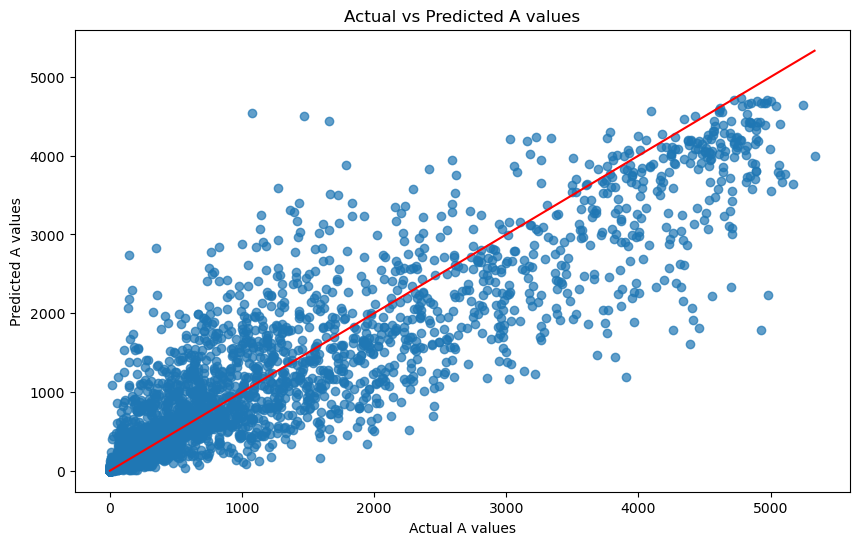

In [186]:
# Get predictions for the test set (already have y_test_A for actual values)
y_pred_A_test = xgb_A.predict(X_test_A)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_A, y_pred_A_test, alpha=0.7)
plt.xlabel('Actual A values')
plt.ylabel('Predicted A values')
plt.title('Actual vs Predicted A values')
plt.plot([min(y_test_A), max(y_test_A)], [min(y_test_A), max(y_test_A)], color='red')  # Diagonal line
plt.show()



In [187]:
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, shuffle=False)

from sklearn.model_selection import RandomizedSearchCV

# Define middle parameters for B
middle_params_B = {
    'n_estimators': 500,
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.7,
    'gamma': 0.2,
    'min_child_weight': 1,
    'reg_alpha': 0.1,
    'reg_lambda': 1
}

# Initialize XGBRegressor with the middle parameters for B
xgb_B = XGBRegressor(
    random_state=0,
    booster='gbtree',
    n_estimators=middle_params_B['n_estimators'],
    learning_rate=middle_params_B['learning_rate'],
    max_depth=middle_params_B['max_depth'],
    subsample=middle_params_B['subsample'],
    colsample_bytree=middle_params_B['colsample_bytree'],
    gamma=middle_params_B['gamma'],
    min_child_weight=middle_params_B['min_child_weight'],
    reg_alpha=middle_params_B['reg_alpha'],
    reg_lambda=middle_params_B['reg_lambda']
)

# Fit the XGBRegressor with the training set
print('Fitting with middle parameters...')
xgb_B.fit(X_train_B, y_train_B, eval_set=[(X_train_B, y_train_B), (X_test_B, y_test_B)], eval_metric="mae", verbose=True)
evals_results_B = xgb_B.evals_result()

# Make predictions with the model
pred_B = xgb_B.predict(test_B)
pred_B = np.clip(pred_B, 0, None) # Use np.clip to ensure predictions are non-negative




Fitting with middle parameters...
[0]	validation_0-mae:106.92916	validation_1-mae:52.18535
[1]	validation_0-mae:105.93548	validation_1-mae:51.78989
[2]	validation_0-mae:104.99786	validation_1-mae:51.39144
[3]	validation_0-mae:104.03264	validation_1-mae:50.99514
[4]	validation_0-mae:103.10537	validation_1-mae:50.62657
[5]	validation_0-mae:102.15154	validation_1-mae:50.24059
[6]	validation_0-mae:101.21442	validation_1-mae:49.87296
[7]	validation_0-mae:100.29076	validation_1-mae:49.56417


/Users/petterdalhaug/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[8]	validation_0-mae:99.36489	validation_1-mae:49.23591
[9]	validation_0-mae:98.46294	validation_1-mae:48.92080
[10]	validation_0-mae:97.57120	validation_1-mae:48.58995
[11]	validation_0-mae:96.68332	validation_1-mae:48.35716
[12]	validation_0-mae:95.80644	validation_1-mae:48.02897
[13]	validation_0-mae:94.93777	validation_1-mae:47.73392
[14]	validation_0-mae:94.07331	validation_1-mae:47.41954
[15]	validation_0-mae:93.24262	validation_1-mae:47.22875
[16]	validation_0-mae:92.40237	validation_1-mae:46.91910
[17]	validation_0-mae:91.56348	validation_1-mae:46.67393
[18]	validation_0-mae:90.78114	validation_1-mae:46.50794
[19]	validation_0-mae:89.97398	validation_1-mae:46.30778
[20]	validation_0-mae:89.17078	validation_1-mae:46.08026
[21]	validation_0-mae:88.37731	validation_1-mae:45.88215
[22]	validation_0-mae:87.58631	validation_1-mae:45.63435
[23]	validation_0-mae:86.83053	validation_1-mae:45.46746
[24]	validation_0-mae:86.11802	validation_1-mae:45.24590
[25]	validation_0-mae:85.37887	va

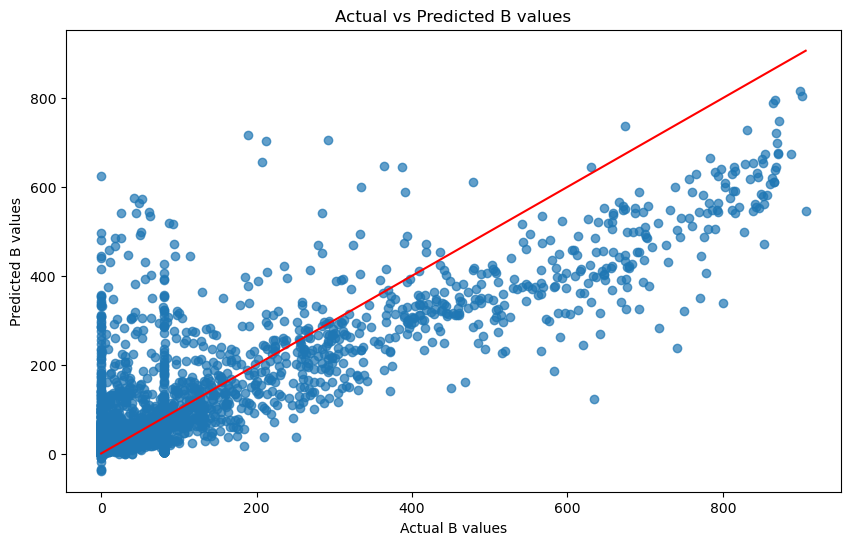

In [188]:
# Get predictions for the test set (already have y_test_B for actual values)
y_pred_B_test = xgb_B.predict(X_test_B)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_B, y_pred_B_test, alpha=0.7)
plt.xlabel('Actual B values')
plt.ylabel('Predicted B values')
plt.title('Actual vs Predicted B values')
plt.plot([min(y_test_B), max(y_test_B)], [min(y_test_B), max(y_test_B)], color='red')  # Diagonal line
plt.show()




In [189]:
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2, shuffle=False)

# Initialize XGBRegressor with the best hyperparameters
# Define hyperparameter grid for model C
# Define middle parameters for C
middle_params_C = {
    'n_estimators': 500,  # Middle value between 400 and 600
    'learning_rate': 0.05, # Middle value between 0.01 and 0.1
    'max_depth': 6,        # Middle value between 4 and 8
    'subsample': 0.9,      # Higher of the two middle values
    'colsample_bytree': 0.7, # Higher of the two middle values
    'gamma': 0.2,          # Higher of the two values
    'min_child_weight': 5, # Higher of the two values since only two options
    'reg_alpha': 0.1,      # Higher of the two values since only two options
    'reg_lambda': 1.25     # Middle value between 1 and 1.5
}

xgb_C = XGBRegressor(
    random_state=0,
    booster='gbtree',
    n_estimators=middle_params_C['n_estimators'],
    learning_rate=middle_params_C['learning_rate'],
    max_depth=middle_params_C['max_depth'],
    subsample=middle_params_C['subsample'],
    colsample_bytree=middle_params_C['colsample_bytree'],
    gamma=middle_params_C['gamma'],
    min_child_weight=middle_params_C['min_child_weight'],
    reg_alpha=middle_params_C['reg_alpha'],
    reg_lambda=middle_params_C['reg_lambda']
)

print('Fitting with middle parameters...')
xgb_C.fit(X_train_C, y_train_C, eval_set=[(X_train_C, y_train_C), (X_test_C, y_test_C)], eval_metric="mae", verbose=True)
evals_results_C = xgb_C.evals_result()

# Ensure 'test_C' is your test features and not an empty dataset
pred_C = xgb_C.predict(test_C)
pred_C = np.clip(pred_C, 0, None)




Fitting with middle parameters...
[0]	validation_0-mae:81.24382	validation_1-mae:45.21790
[1]	validation_0-mae:77.36049	validation_1-mae:43.29620
[2]	validation_0-mae:73.69947	validation_1-mae:41.50386
[3]	validation_0-mae:70.25617	validation_1-mae:39.80316
[4]	validation_0-mae:67.00995	validation_1-mae:38.25444
[5]	validation_0-mae:63.91886	validation_1-mae:36.70074
[6]	validation_0-mae:61.01201	validation_1-mae:35.42454


/Users/petterdalhaug/anaconda3/envs/TDT4173-MPC/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[7]	validation_0-mae:58.27941	validation_1-mae:34.24246
[8]	validation_0-mae:55.72468	validation_1-mae:33.16555
[9]	validation_0-mae:53.31295	validation_1-mae:32.15229
[10]	validation_0-mae:51.03799	validation_1-mae:31.25095
[11]	validation_0-mae:48.93684	validation_1-mae:30.39740
[12]	validation_0-mae:46.94952	validation_1-mae:29.61750
[13]	validation_0-mae:45.09257	validation_1-mae:28.90179
[14]	validation_0-mae:43.37544	validation_1-mae:28.23883
[15]	validation_0-mae:41.77765	validation_1-mae:27.66176
[16]	validation_0-mae:40.25590	validation_1-mae:27.11345
[17]	validation_0-mae:38.85270	validation_1-mae:26.67622
[18]	validation_0-mae:37.55153	validation_1-mae:26.24844
[19]	validation_0-mae:36.30574	validation_1-mae:25.82753
[20]	validation_0-mae:35.20977	validation_1-mae:25.50776
[21]	validation_0-mae:34.13264	validation_1-mae:25.19729
[22]	validation_0-mae:33.10537	validation_1-mae:24.88206
[23]	validation_0-mae:32.18102	validation_1-mae:24.63783
[24]	validation_0-mae:31.30603	val

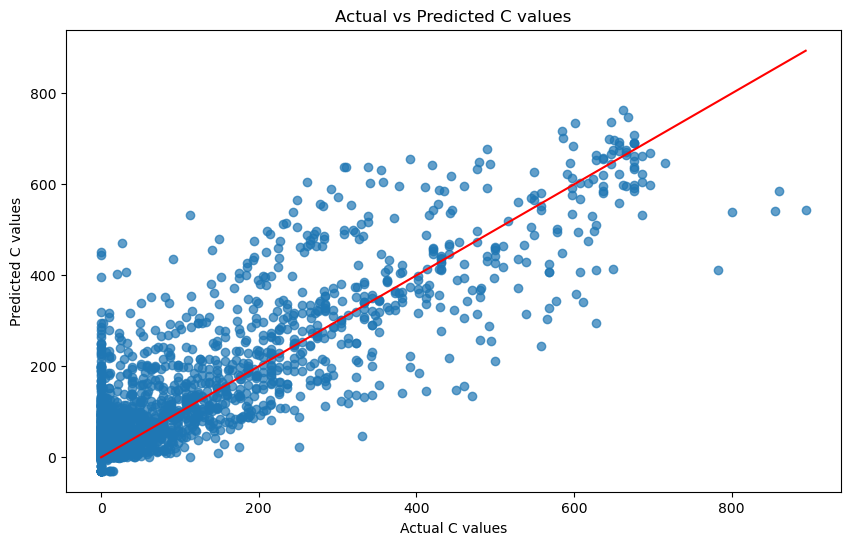

In [190]:
# Get predictions for the test set (already have y_test_C for actual values)
y_pred_C_test = xgb_C.predict(X_test_C)

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_C, y_pred_C_test, alpha=0.7)
plt.xlabel('Actual C values')
plt.ylabel('Predicted C values')
plt.title('Actual vs Predicted C values')
plt.plot([min(y_test_C), max(y_test_C)], [min(y_test_C), max(y_test_C)], color='red')  # Diagonal line
plt.show()


In [191]:
# Assuming pred_A, pred_B, and pred_C are your prediction arrays
print(pred_A.shape)  # Check if pred_A is 1-D; it should look like (n_samples,)
print(pred_B.shape)  # Check if pred_B is 1-D; it should look like (n_samples,)
print(pred_C.shape)  # Check if pred_C is 1-D; it should look like (n_samples,)

# If they are not 1-D, you can flatten them using ravel() or flatten()
pred_A = pred_A.ravel()
pred_B = pred_B.ravel()
pred_C = pred_C.ravel()

# Then try creating your submission again
create_submission(pred_A, pred_B, pred_C, output_file="../../submission.csv")


(1536,)
(1536,)
(1536,)
Submission saved to ../../submission.csv
